In [393]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from statsmodels.stats.outliers_influence import variance_inflation_factor
import math


In [394]:
df = pd.read_csv("DuLieuLichSu VN Index - Ngay.csv")
fx = pd.read_csv("Dữ liệu Lịch sử USD_VND.csv")
df_trendline = pd.read_csv("multiTimeline.csv")
df.head()
df.info()
print(fx.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6123 entries, 0 to 6122
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Date      6123 non-null   object
 1   Price     6123 non-null   object
 2   Open      6123 non-null   object
 3   High      6123 non-null   object
 4   Low       6123 non-null   object
 5   Vol.      6117 non-null   object
 6   Change %  6123 non-null   object
dtypes: object(7)
memory usage: 335.0+ KB
         Date     Close      Open      High       Low  Vol % Change
0  2000-09-29  14,212.0  14,212.0  14,212.0  14,212.0  NaN    0.04%
1  2000-10-02  14,218.0  14,218.0  14,218.0  14,218.0  NaN    0.04%
2  2000-10-03  14,232.0  14,232.0  14,232.0  14,232.0  NaN    0.10%
3  2000-10-04  14,240.0  14,240.0  14,240.0  14,240.0  NaN    0.06%
4  2000-10-05  14,248.0  14,248.0  14,248.0  14,248.0  NaN    0.06%


In [395]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
fx['Date'] = pd.to_datetime(fx['Date'], errors='coerce')
fx.rename(columns={'Close': 'USD/VND'}, inplace=True)
fx = fx[['Date', 'USD/VND']]

print("df Date dtype:", df['Date'].dtype)
print("fx Date dtype:", fx['Date'].dtype)

df = pd.merge(df, fx, on='Date', how='left')

print(df[['Date', 'USD/VND']].head())
print("Số giá trị thiếu trong tỷ giá:", df['USD/VND'].isna().sum())

df.columns



df Date dtype: datetime64[ns]
fx Date dtype: datetime64[ns]
        Date   USD/VND
0 2000-10-02  14,218.0
1 2000-10-04  14,240.0
2 2000-10-06  14,248.0
3 2000-10-09  14,261.0
4 2000-10-11  14,248.0
Số giá trị thiếu trong tỷ giá: 2


Index(['Date', 'Price', 'Open', 'High', 'Low', 'Vol.', 'Change %', 'USD/VND'], dtype='object')

In [396]:
df.columns = [col.strip().lower() for col in df.columns]
df.rename(columns={
    'price': 'close',
    'vol.': 'volume',
    'change %': 'change_pct'
}, inplace=True)

In [397]:
def convert_volume(x):
    if isinstance(x, str):
        x = x.replace(',', '').replace('-', '0').strip()
        if 'M' in x:
            return float(x.replace('M', '')) * 1_000_000
        elif 'K' in x:
            return float(x.replace('K', '')) * 1_000
        elif 'B' in x:
            return float(x.replace('B', '')) * 1_000_000_000
        else:
            return float(x)
    return x

df['volume'] = df['volume'].apply(convert_volume)
df['change_pct'] = df['change_pct'].str.replace('%', '', regex=False).astype(float)
for col in ['open', 'high', 'low', 'close']:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', ''), errors='coerce')
df.dropna(subset=['date', 'close'], inplace=True)
df = df[df['volume'] > 0]

df.sort_values('date', inplace=True)
df.reset_index(drop=True, inplace=True)

print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6115 entries, 0 to 6114
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        6115 non-null   datetime64[ns]
 1   close       6115 non-null   float64       
 2   open        6115 non-null   float64       
 3   high        6115 non-null   float64       
 4   low         6115 non-null   float64       
 5   volume      6115 non-null   float64       
 6   change_pct  6115 non-null   float64       
 7   usd/vnd     6113 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 382.3+ KB
None
        date   close    open    high     low  volume  change_pct   usd/vnd
0 2000-10-02  120.92  120.92  120.92  120.92    50.0        0.17  14,218.0
1 2000-10-04  121.14  121.14  121.14  121.14    60.0        0.18  14,240.0
2 2000-10-06  122.21  122.21  122.21  122.21    40.0        0.88  14,248.0
3 2000-10-09  124.33  124.33  124.33

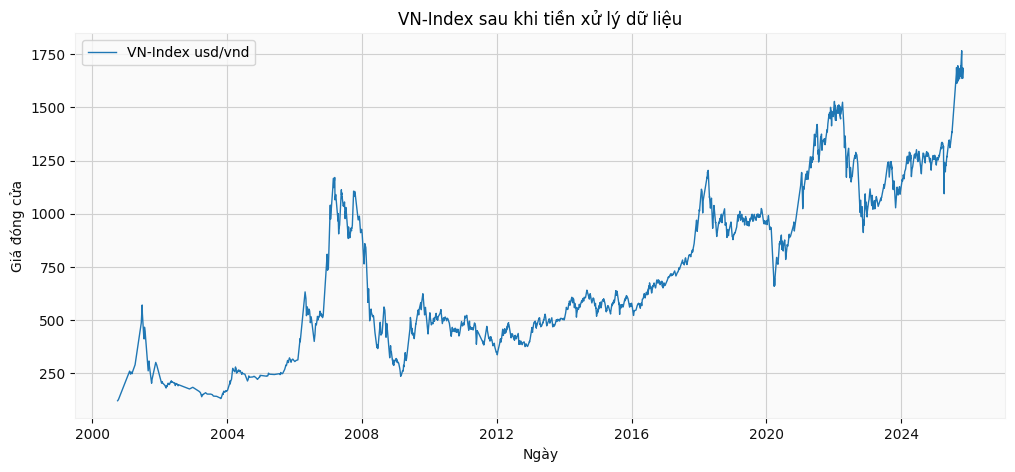

Index(['date', 'close', 'open', 'high', 'low', 'volume', 'change_pct',
       'usd/vnd'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6115 entries, 0 to 6114
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        6115 non-null   datetime64[ns]
 1   close       6115 non-null   float64       
 2   open        6115 non-null   float64       
 3   high        6115 non-null   float64       
 4   low         6115 non-null   float64       
 5   volume      6115 non-null   float64       
 6   change_pct  6115 non-null   float64       
 7   usd/vnd     6113 non-null   object        
dtypes: datetime64[ns](1), float64(6), object(1)
memory usage: 382.3+ KB


In [398]:
plt.figure(figsize=(12, 5))
plt.plot(df['date'], df['close'], label='VN-Index usd/vnd', linewidth=1)
plt.title("VN-Index sau khi tiền xử lý dữ liệu")
plt.xlabel("Ngày")
plt.ylabel("Giá đóng cửa")
plt.legend()
plt.grid(True)
plt.show()
print(df.columns)
df.head()
df.info()


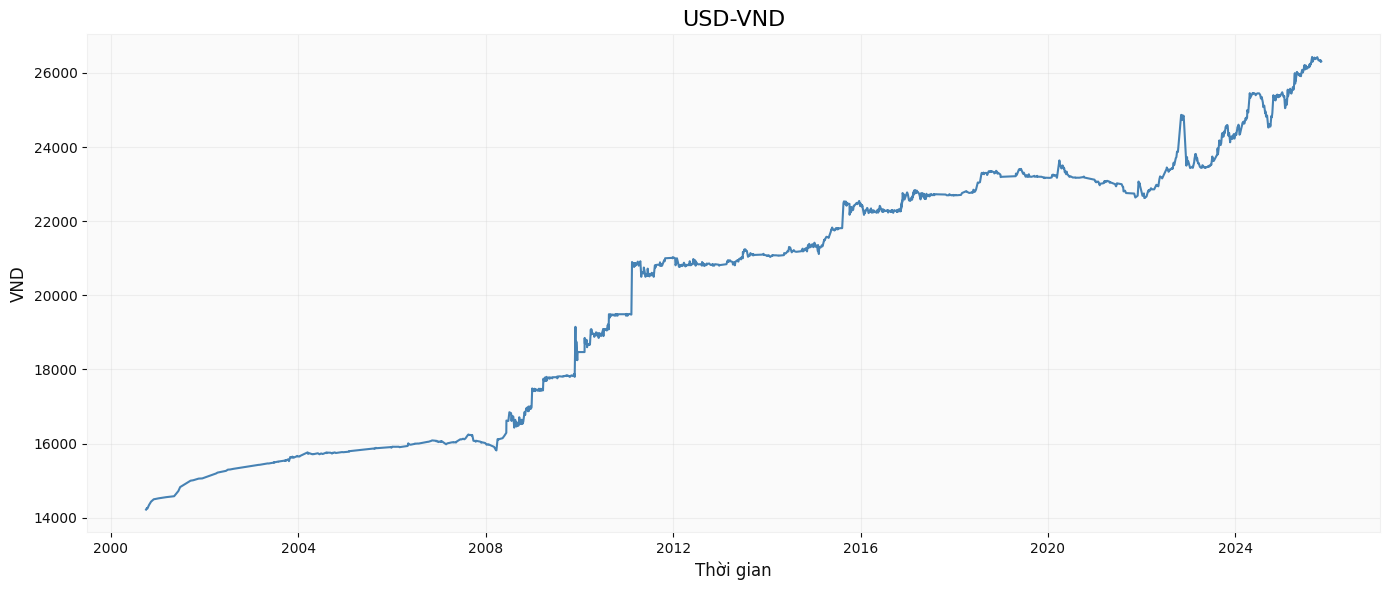

In [399]:
df['usd/vnd'] = (
    df['usd/vnd']
    .astype(str)
    .str.replace(',', '')  # loại dấu phẩy nếu có
    .astype(float)
)

# Vẽ biểu đồ
plt.figure(figsize=(14,6))
plt.plot(df['date'], df['usd/vnd'], color='steelblue', linewidth=1.5)
plt.title('USD-VND', fontsize=16)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('VND', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

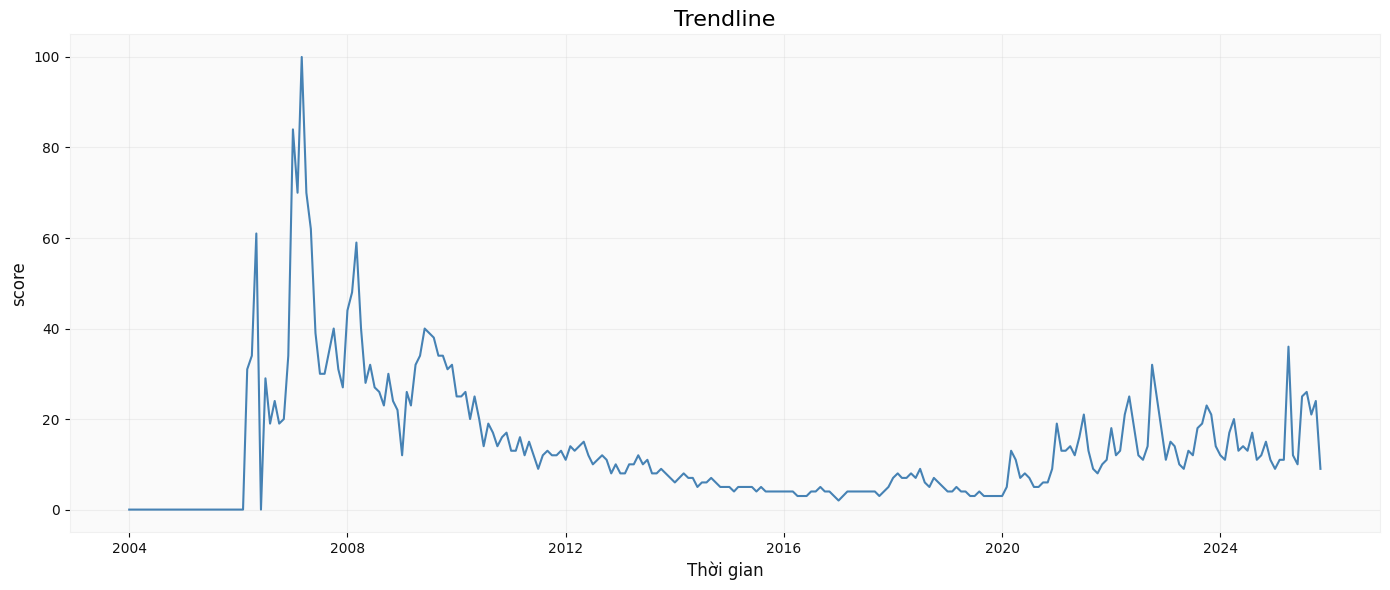

In [400]:
df_trendline['Tháng'] = pd.to_datetime(df_trendline['Tháng'], errors='coerce')
df_trendline['Vn-Index'] = (
    df_trendline['Vn-Index']
    .astype(str)
    .str.replace(',', '')  # loại dấu phẩy nếu có
    .astype(float)
)
df_trendline = df_trendline.sort_values('Tháng')

# Vẽ biểu đồ
plt.figure(figsize=(14,6))
plt.plot(df_trendline['Tháng'], df_trendline['Vn-Index'], color='steelblue', linewidth=1.5)
plt.title('Trendline', fontsize=16)
plt.xlabel('Thời gian', fontsize=12)
plt.ylabel('score', fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [402]:
# Chuẩn hóa tên cột
df.columns = df.columns.str.strip().str.capitalize()
df = df.sort_values('Date')
num_cols = ['Open', 'High', 'Low', 'Close', 'Vol.']

def clean_num(value):
    if pd.isna(value):
        return np.nan
    value = str(value).replace(',', '').strip()
    if value.endswith('K'):
        return float(value[:-1]) * 1_000
    elif value.endswith('M'):
        return float(value[:-1]) * 1_000_000
    elif value.endswith('B'):
        return float(value[:-1]) * 1_000_000_000
    else:
        try:
            return float(value)
        except ValueError:
            return np.nan

for col in num_cols:
    if col in df.columns:
        df[col] = df[col].apply(clean_num)


In [403]:
# Đặt index theo thời gian
df.set_index('Date', inplace=True, drop =False)


# EMA20, EMA50
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()
df['EMA50'] = df['Close'].ewm(span=50, adjust=False).mean()

# === SMA20, SMA50 ===
df['SMA20'] = df['Close'].rolling(window=20).mean()
df['SMA50'] = df['Close'].rolling(window=50).mean()

# Bollinger Bands
df['BB_Middle'] = df['Close'].rolling(window=20).mean()
df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()
df['BB_Width'] = (df['BB_Upper'] - df['BB_Lower']) / df['BB_Middle']

# RSI (14)
delta = df['Close'].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.rolling(14).mean()
avg_loss = loss.rolling(14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# MACD
ema_12 = df['Close'].ewm(span=12, adjust=False).mean()
ema_26 = df['Close'].ewm(span=26, adjust=False).mean()
df['MACD'] = ema_12 - ema_26
df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


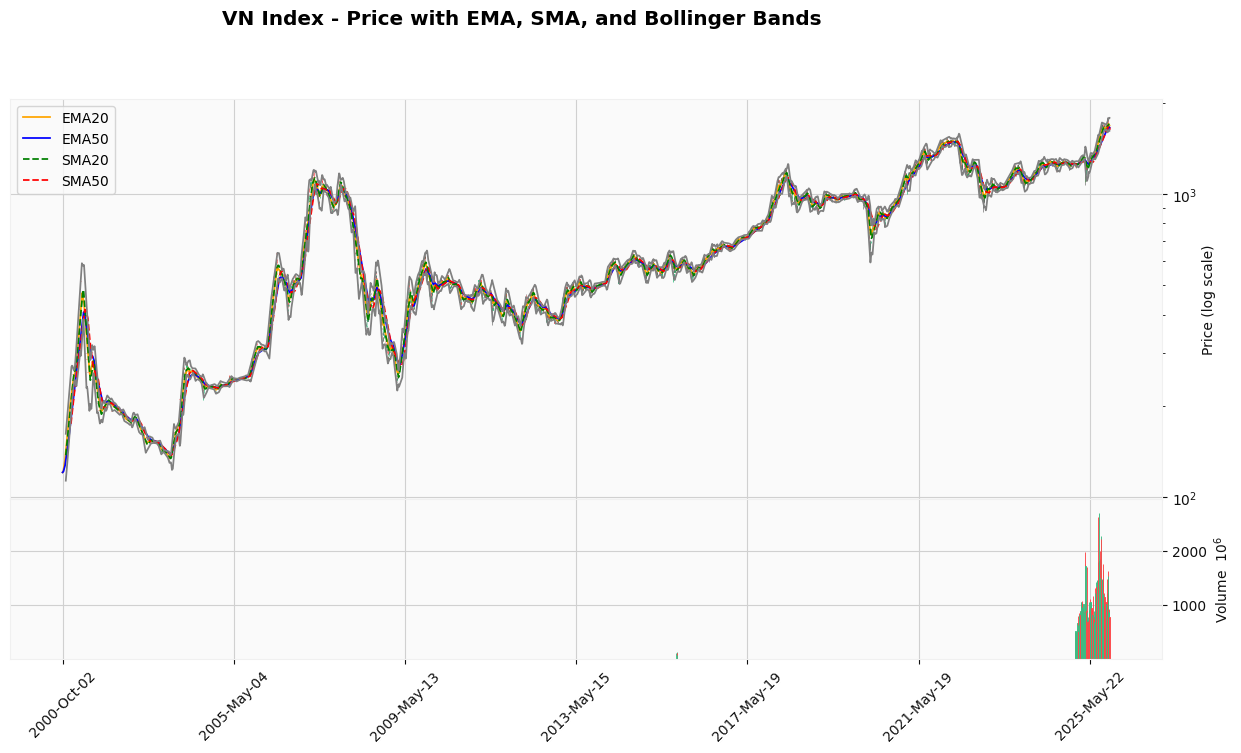

In [404]:
df.rename(columns={'Vol.': 'Volume'}, inplace=True)

apds = [
    mpf.make_addplot(df['EMA20'], color='orange', label='EMA20'),
    mpf.make_addplot(df['EMA50'], color='blue', label='EMA50'),
    mpf.make_addplot(df['SMA20'], color='green', linestyle='--', label='SMA20'),
    mpf.make_addplot(df['SMA50'], color='red', linestyle='--', label='SMA50'),
    mpf.make_addplot(df['BB_Upper'], color='gray'),
    mpf.make_addplot(df['BB_Lower'], color='gray')
]

mpf.plot(
    df,
    type='candle',
    style='yahoo',
    title='VN Index - Price with EMA, SMA, and Bollinger Bands',
    ylabel='Price (log scale)',
    addplot=apds,
    volume=True,
    figsize=(16, 8),
    yscale='log'
)


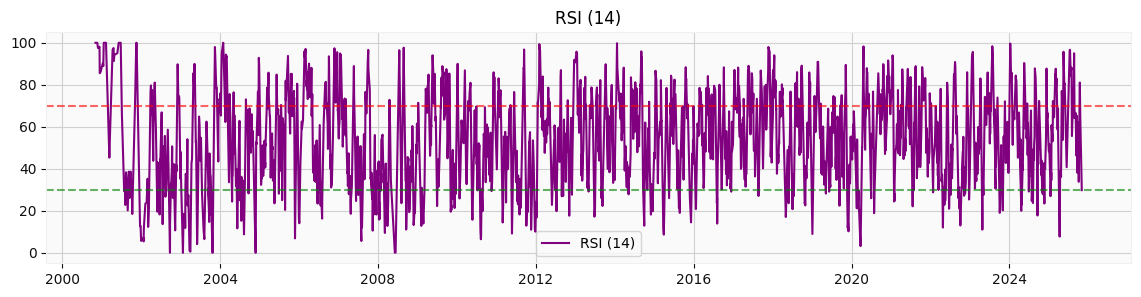

In [405]:
plt.figure(figsize=(14, 3))
plt.plot(df.index, df['RSI'], label='RSI (14)', color='purple')
plt.axhline(70, color='red', linestyle='--', alpha=0.6)
plt.axhline(30, color='green', linestyle='--', alpha=0.6)
plt.title('RSI (14)')
plt.legend()
plt.grid(True)
plt.show()

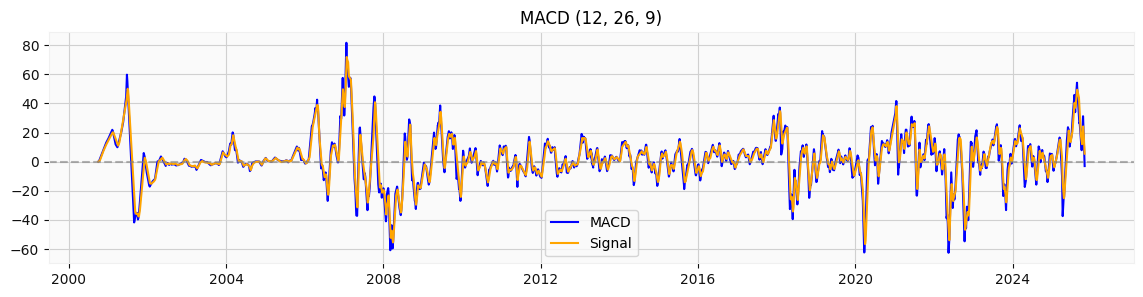

In [406]:
plt.figure(figsize=(14, 3))
plt.plot(df.index, df['MACD'], label='MACD', color='blue')
plt.plot(df.index, df['Signal'], label='Signal', color='orange')
plt.axhline(0, color='gray', linestyle='--', alpha=0.6)
plt.title('MACD (12, 26, 9)')
plt.legend()
plt.grid(True)
plt.show()

In [407]:
# Bỏ index hiện tại và tạo lại từ 0
df.reset_index(drop=True, inplace=True)

In [ ]:
missing = df.isna().sum()
print("Giá trị thiếu:\n", missing[missing > 0])
df = df.dropna()
print("\nSau khi xóa giá trị thiếu:", df.isna().sum().sum(), "giá trị thiếu còn lại.")
print("Kích thước dữ liệu sau khi xóa:", df.shape)

Giá trị thiếu:
 Usd/vnd       2
SMA20        19
SMA50        49
BB_Middle    19
BB_Upper     19
BB_Lower     19
BB_Width     19
RSI          14
dtype: int64

Sau khi xóa giá trị thiếu: 0 giá trị thiếu còn lại.
Kích thước dữ liệu sau khi xóa: (6064, 19)


In [410]:
desc = df.describe().T
display(desc)

print("\nThông tin thời gian:")
print("Ngày đầu tiên:", df['Date'].min())
print("Ngày cuối cùng:", df['Date'].max())
print("Số quan sát:", len(df))


,count,mean,min,25%,50%,75%,max,std
Date,6064,2013-09-04 11:09:25.171503872,2001-02-02 00:00:00,2007-08-05 06:00:00,2013-09-07 12:00:00,2019-10-07 06:00:00,2025-10-31 00:00:00,NaN
Close,6064.0,691.308481,130.9,410.91,574.795,994.2375,1766.85,379.588175
Open,6064.0,691.353699,130.91,410.615,576.09,995.16,1766.85,379.541356
High,6064.0,695.606575,130.91,413.6975,579.785,998.6825,1794.58,382.350226
Low,6064.0,686.824979,130.9,409.12,572.04,988.32,1753.5,376.379992
Volume,6064.0,34033892.074538,10.0,8252.5,79930.0,238450.0,2700000000.0,197021537.180539
Change_pct,6064.0,0.041072,-7.37,-0.55,0.06,0.72,6.88,1.435539
Usd/vnd,6064.0,20231.519624,14541.0,16062.0,21075.0,23069.0,26432.5,3403.394032
EMA20,6064.0,689.003487,134.655911,413.596407,572.037901,991.321557,1707.780411,376.96836
EMA50,6064.0,685.348218,137.753472,412.13248,572.694988,987.112085,1657.635417,372.831733



Thông tin thời gian:
Ngày đầu tiên: 2001-02-02 00:00:00
Ngày cuối cùng: 2025-10-31 00:00:00
Số quan sát: 6064


Nhìn vào các thông số thống kê mô tả, ta nhận thấy ở biến Volume có khoảng cách giữa min và max là một khoảng khá xa, khi vẽ boxplot có thể sẽ xuất hiện outlier

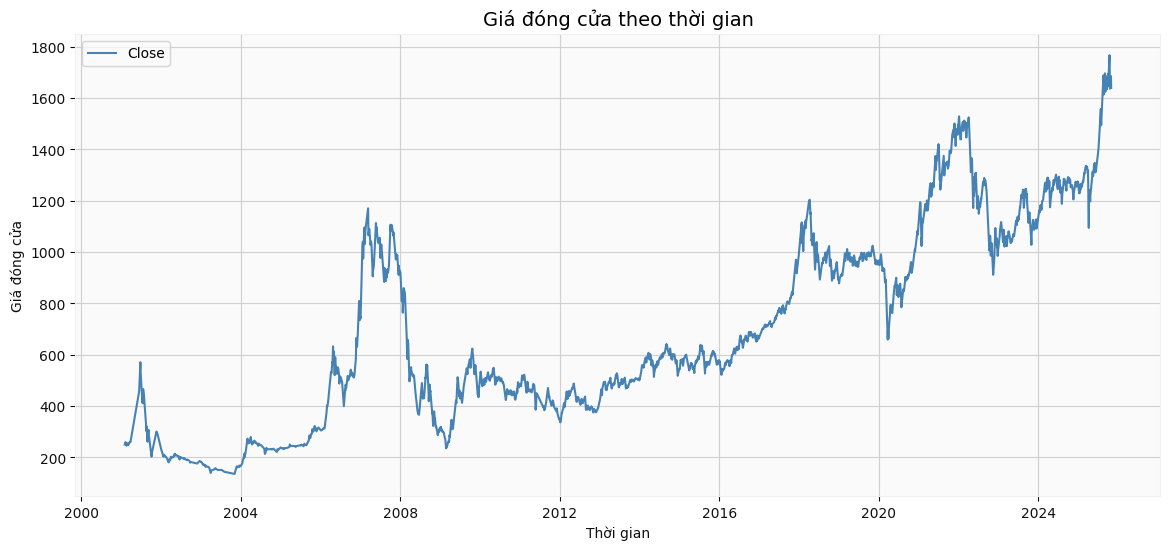

In [411]:
plt.figure(figsize=(14,6))
plt.plot(df['Date'], df['Close'], label='Close', color='steelblue')
plt.title('Giá đóng cửa theo thời gian', fontsize=14)
plt.xlabel('Thời gian')
plt.ylabel('Giá đóng cửa')
plt.legend()
plt.grid(True)
plt.show()


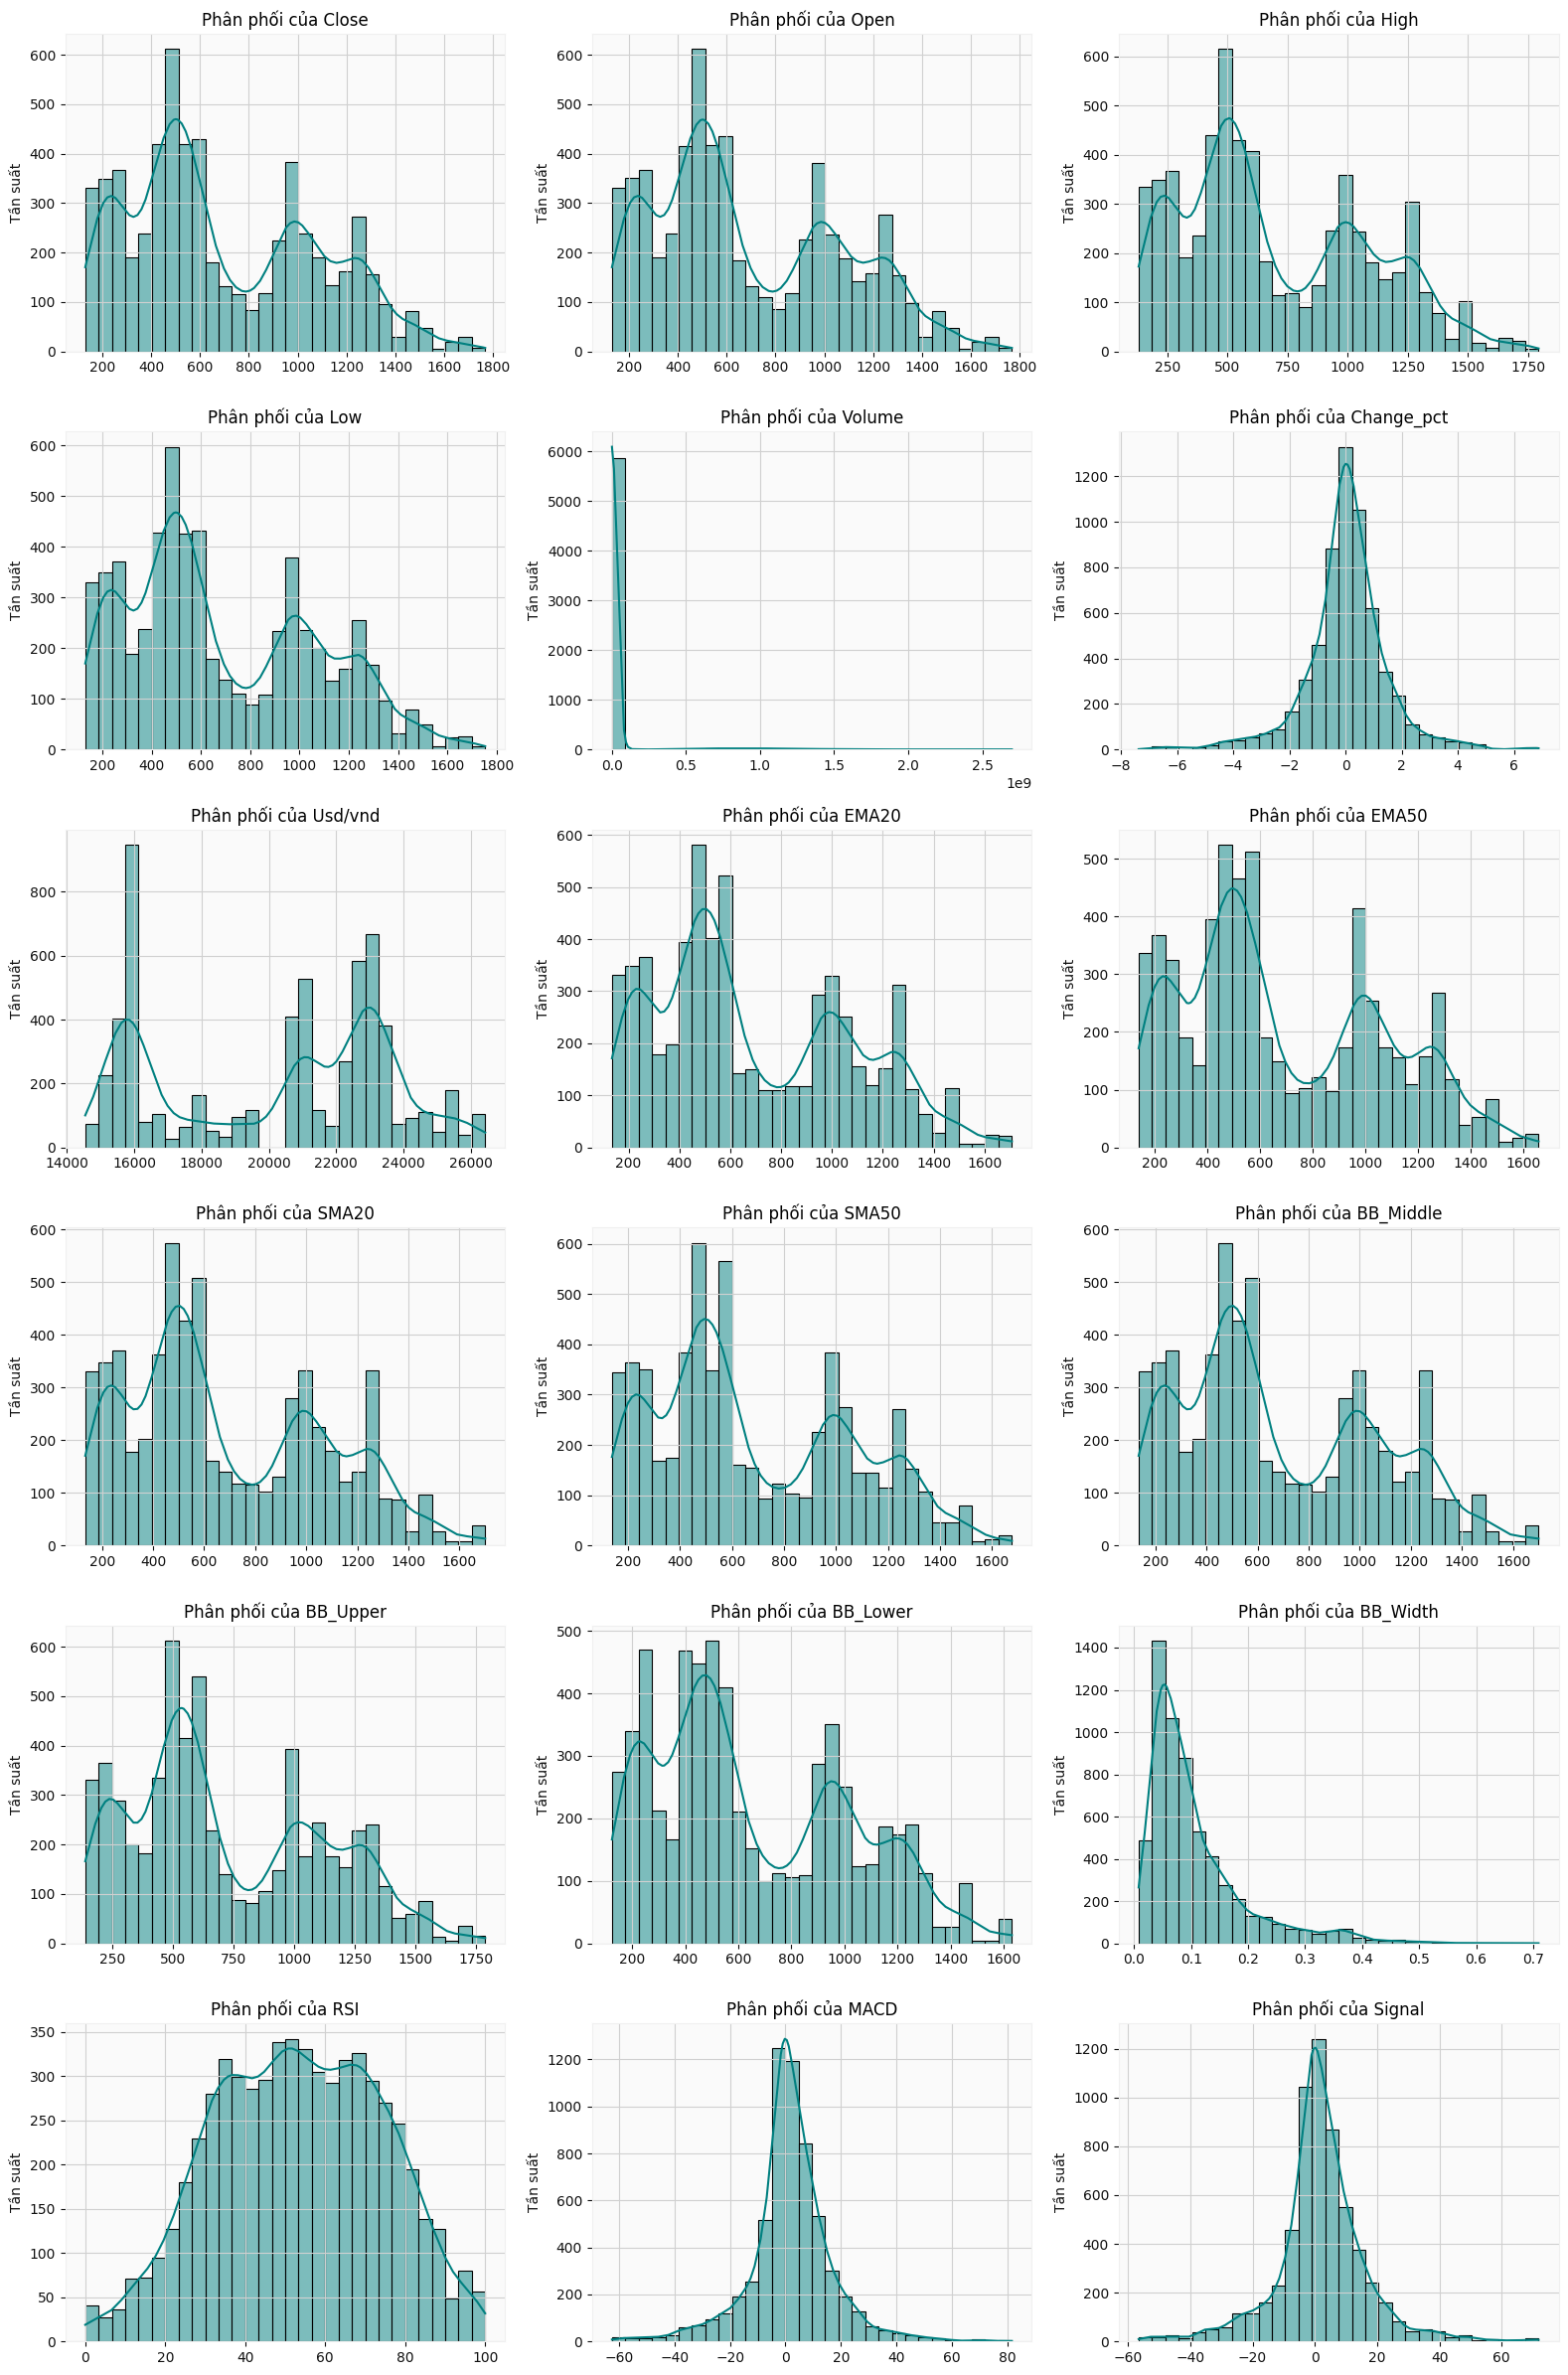

In [412]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
n_cols = 3
n_rows = math.ceil(len(num_cols) / n_cols)

plt.figure(figsize=(16, n_rows * 4))

for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.histplot(df[col], kde=True, bins=30, color='teal')
    plt.title(f'Phân phối của {col}')
    plt.xlabel('')
    plt.ylabel('Tần suất')

plt.tight_layout()
plt.show()


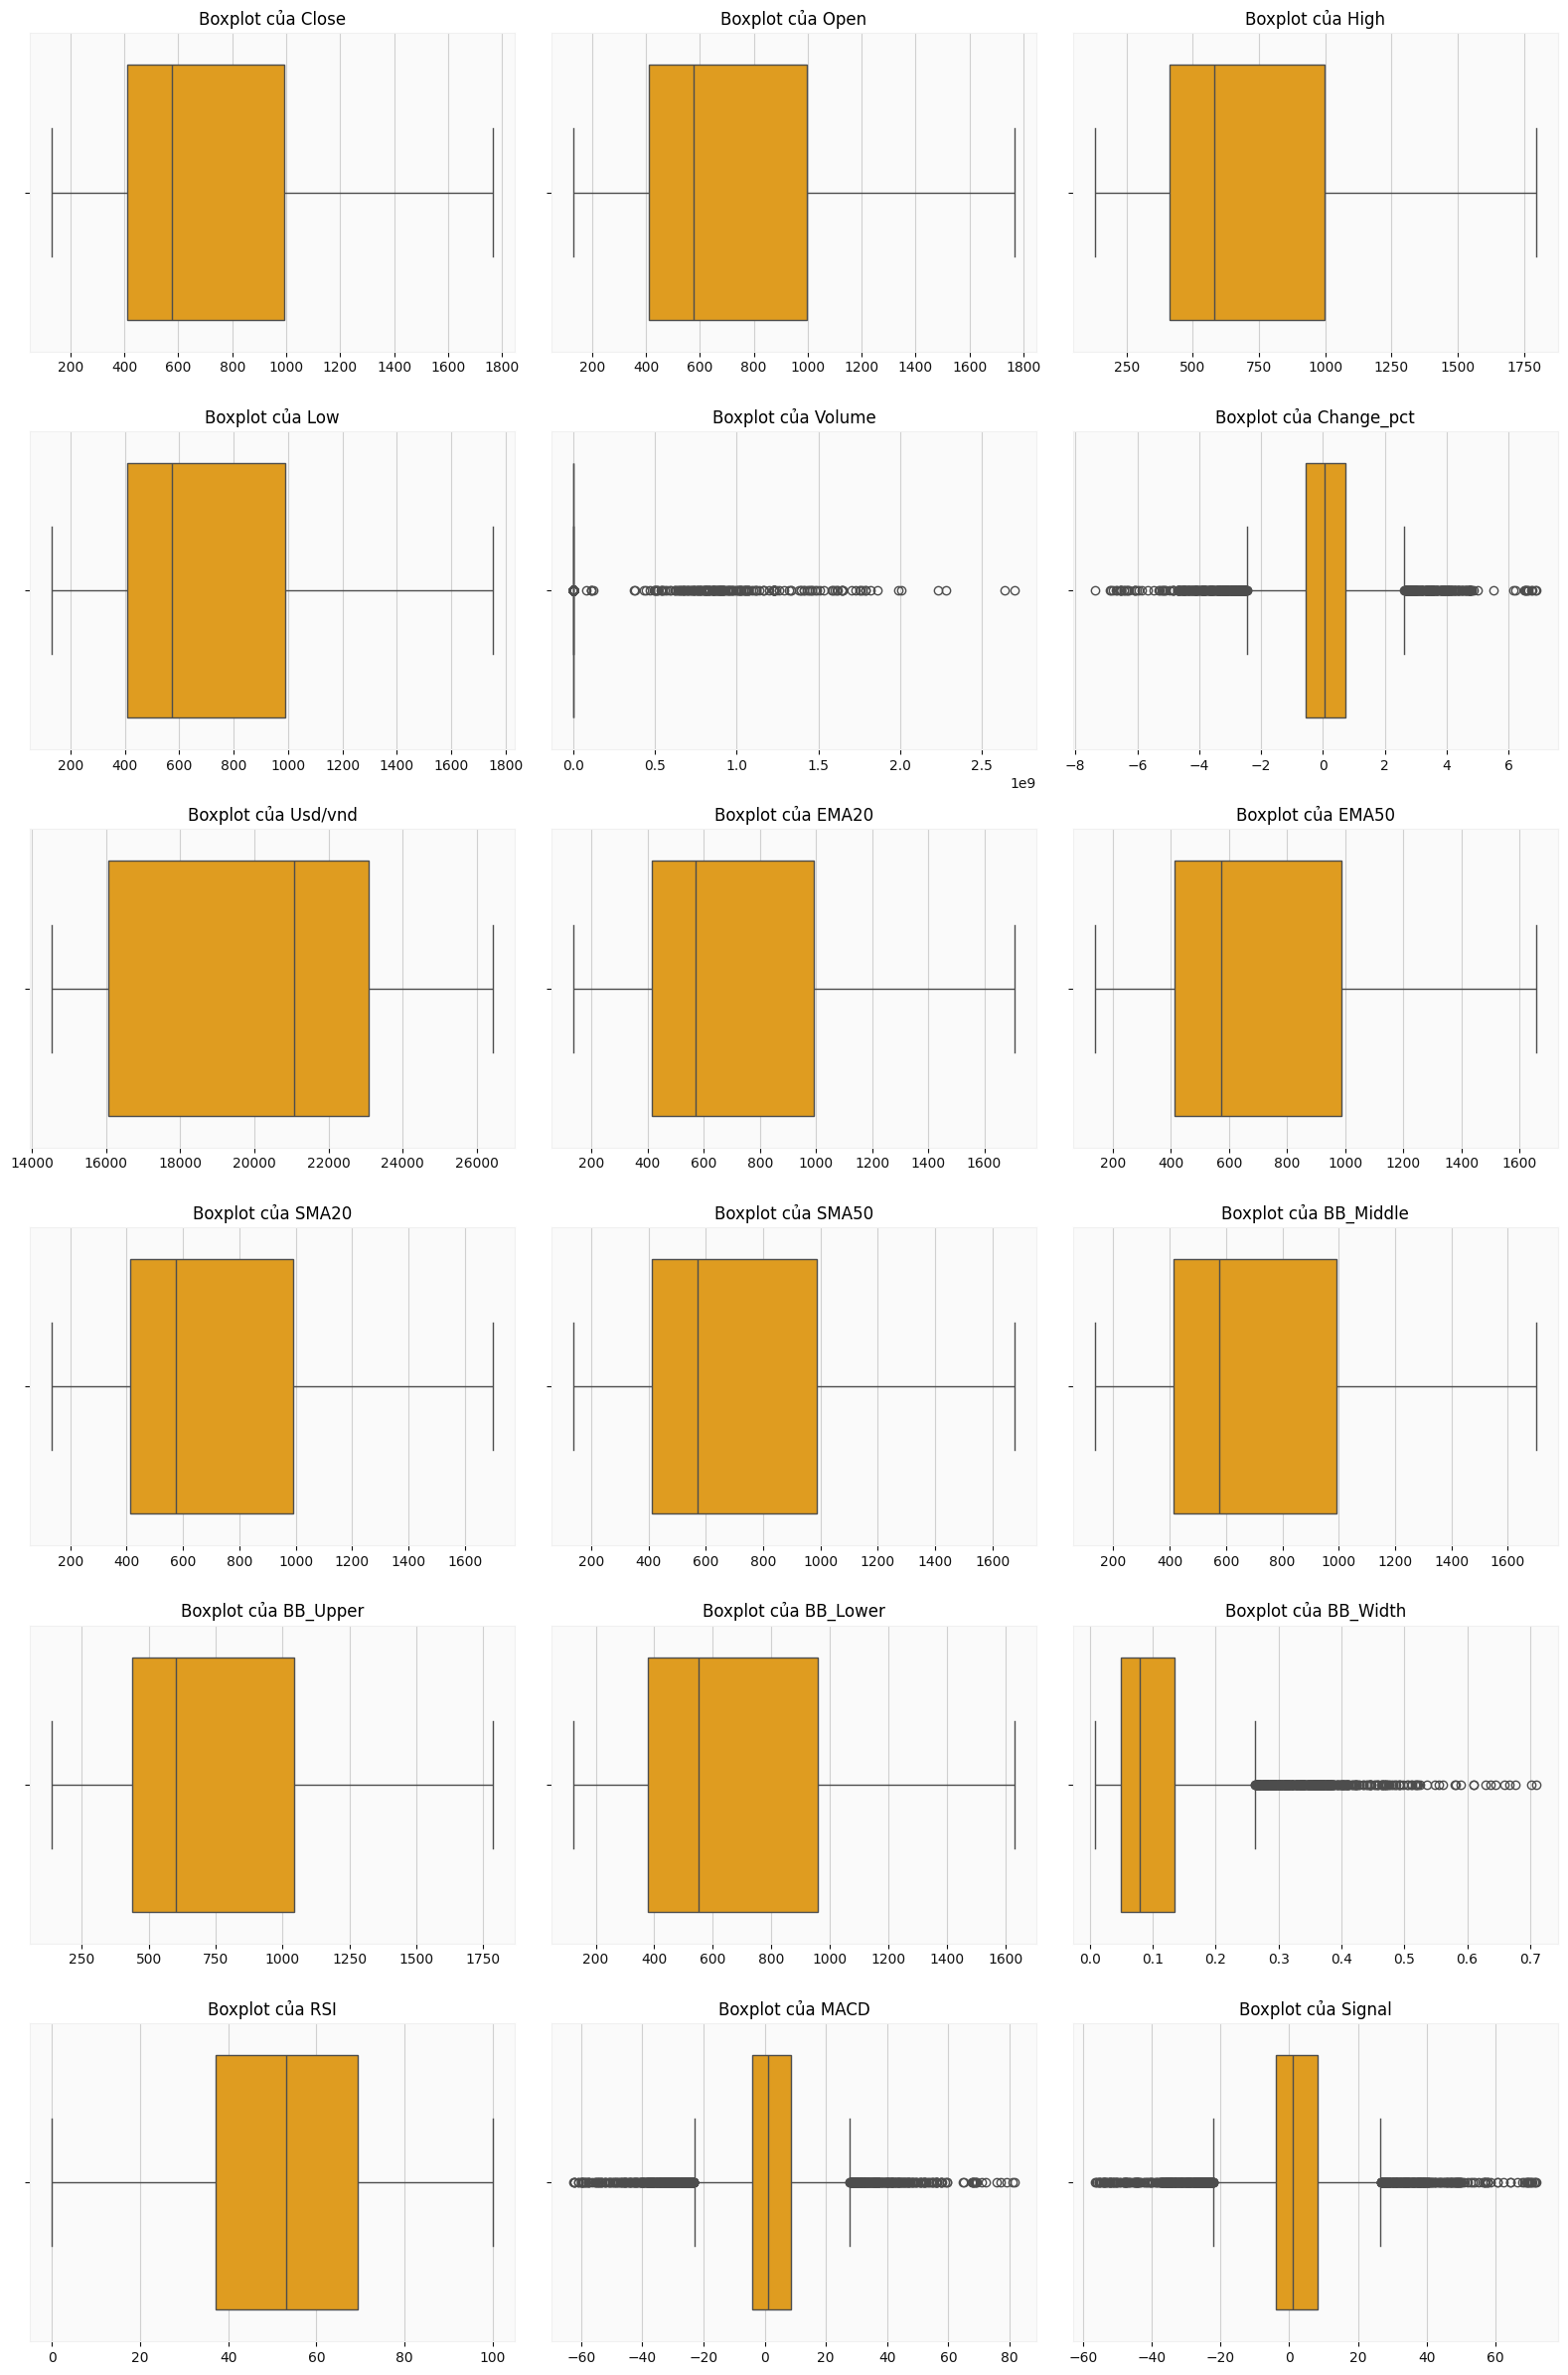

In [413]:
plt.figure(figsize=(16, n_rows * 4))
for i, col in enumerate(num_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=df[col], color='orange')
    plt.title(f'Boxplot của {col}')
    plt.xlabel('')

plt.tight_layout()
plt.show()


In [414]:
desc = df[num_cols].describe().T
desc['skewness'] = df[num_cols].skew()
desc['kurtosis'] = df[num_cols].kurtosis()
print("📊 Thống kê mô tả dữ liệu sau khi tiền xử lý:\n")
display(desc)


📊 Thống kê mô tả dữ liệu sau khi tiền xử lý:



,count,mean,std,min,25%,50%,75%,max,skewness,kurtosis
Close,6064.0,6.913085e+02,3.795882e+02,130.900000,410.910000,574.795000,994.237500,1.766850e+03,0.483856,-0.809033
Open,6064.0,6.913537e+02,3.795414e+02,130.910000,410.615000,576.090000,995.160000,1.766850e+03,0.482748,-0.811514
High,6064.0,6.956066e+02,3.823502e+02,130.910000,413.697500,579.785000,998.682500,1.794580e+03,0.484687,-0.801119
Low,6064.0,6.868250e+02,3.763800e+02,130.900000,409.120000,572.040000,988.320000,1.753500e+03,0.481067,-0.819002
Volume,6064.0,3.403389e+07,1.970215e+08,10.000000,8252.500000,79930.000000,238450.000000,2.700000e+09,6.646531,49.623713
Change_pct,6064.0,4.107190e-02,1.435539e+00,-7.370000,-0.550000,0.060000,0.720000,6.880000e+00,-0.294785,3.525373
Usd/vnd,6064.0,2.023152e+04,3.403394e+03,14541.000000,16062.000000,21075.000000,23069.000000,2.643250e+04,-0.225954,-1.363860
EMA20,6064.0,6.890035e+02,3.769684e+02,134.655911,413.596407,572.037901,991.321557,1.707780e+03,0.471769,-0.846078
EMA50,6064.0,6.853482e+02,3.728317e+02,137.753472,412.132480,572.694988,987.112085,1.657635e+03,0.452850,-0.903516
SMA20,6064.0,6.890103e+02,3.773447e+02,134.361500,412.603250,574.061000,991.373125,1.700384e+03,0.473195,-0.841906


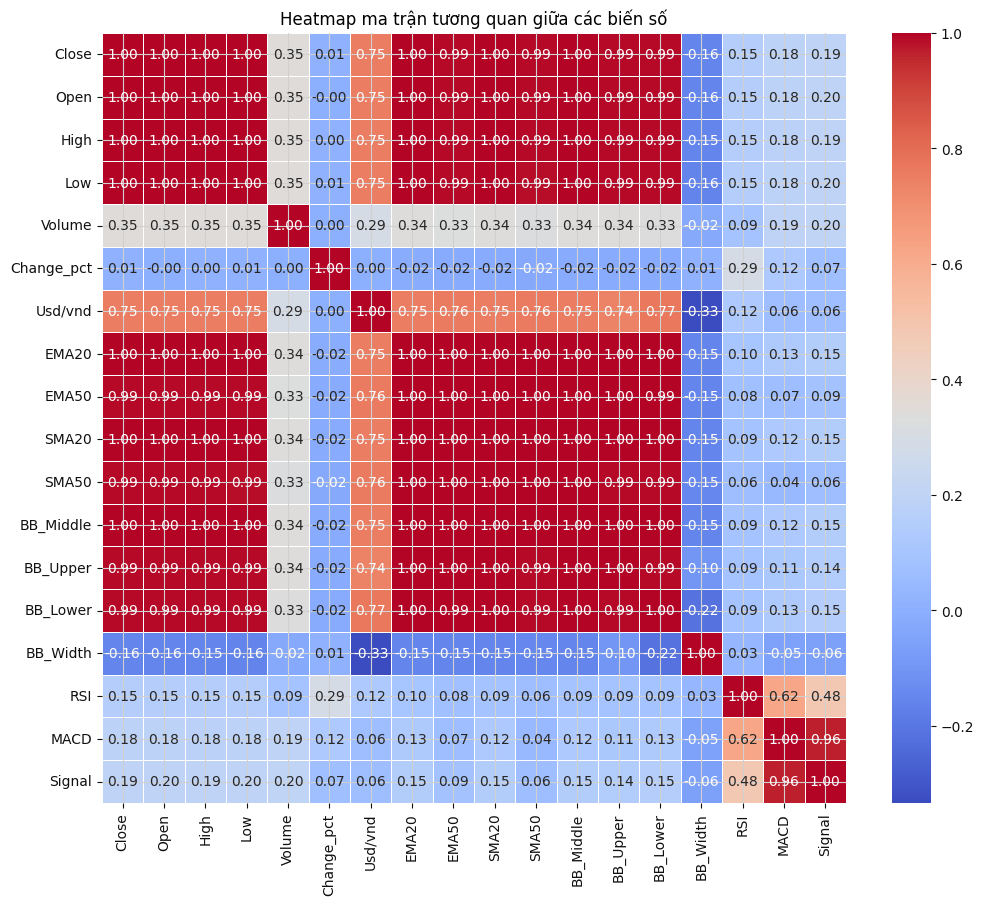

In [415]:
plt.figure(figsize=(12, 10))
corr = df[num_cols].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Heatmap ma trận tương quan giữa các biến số')
plt.show()



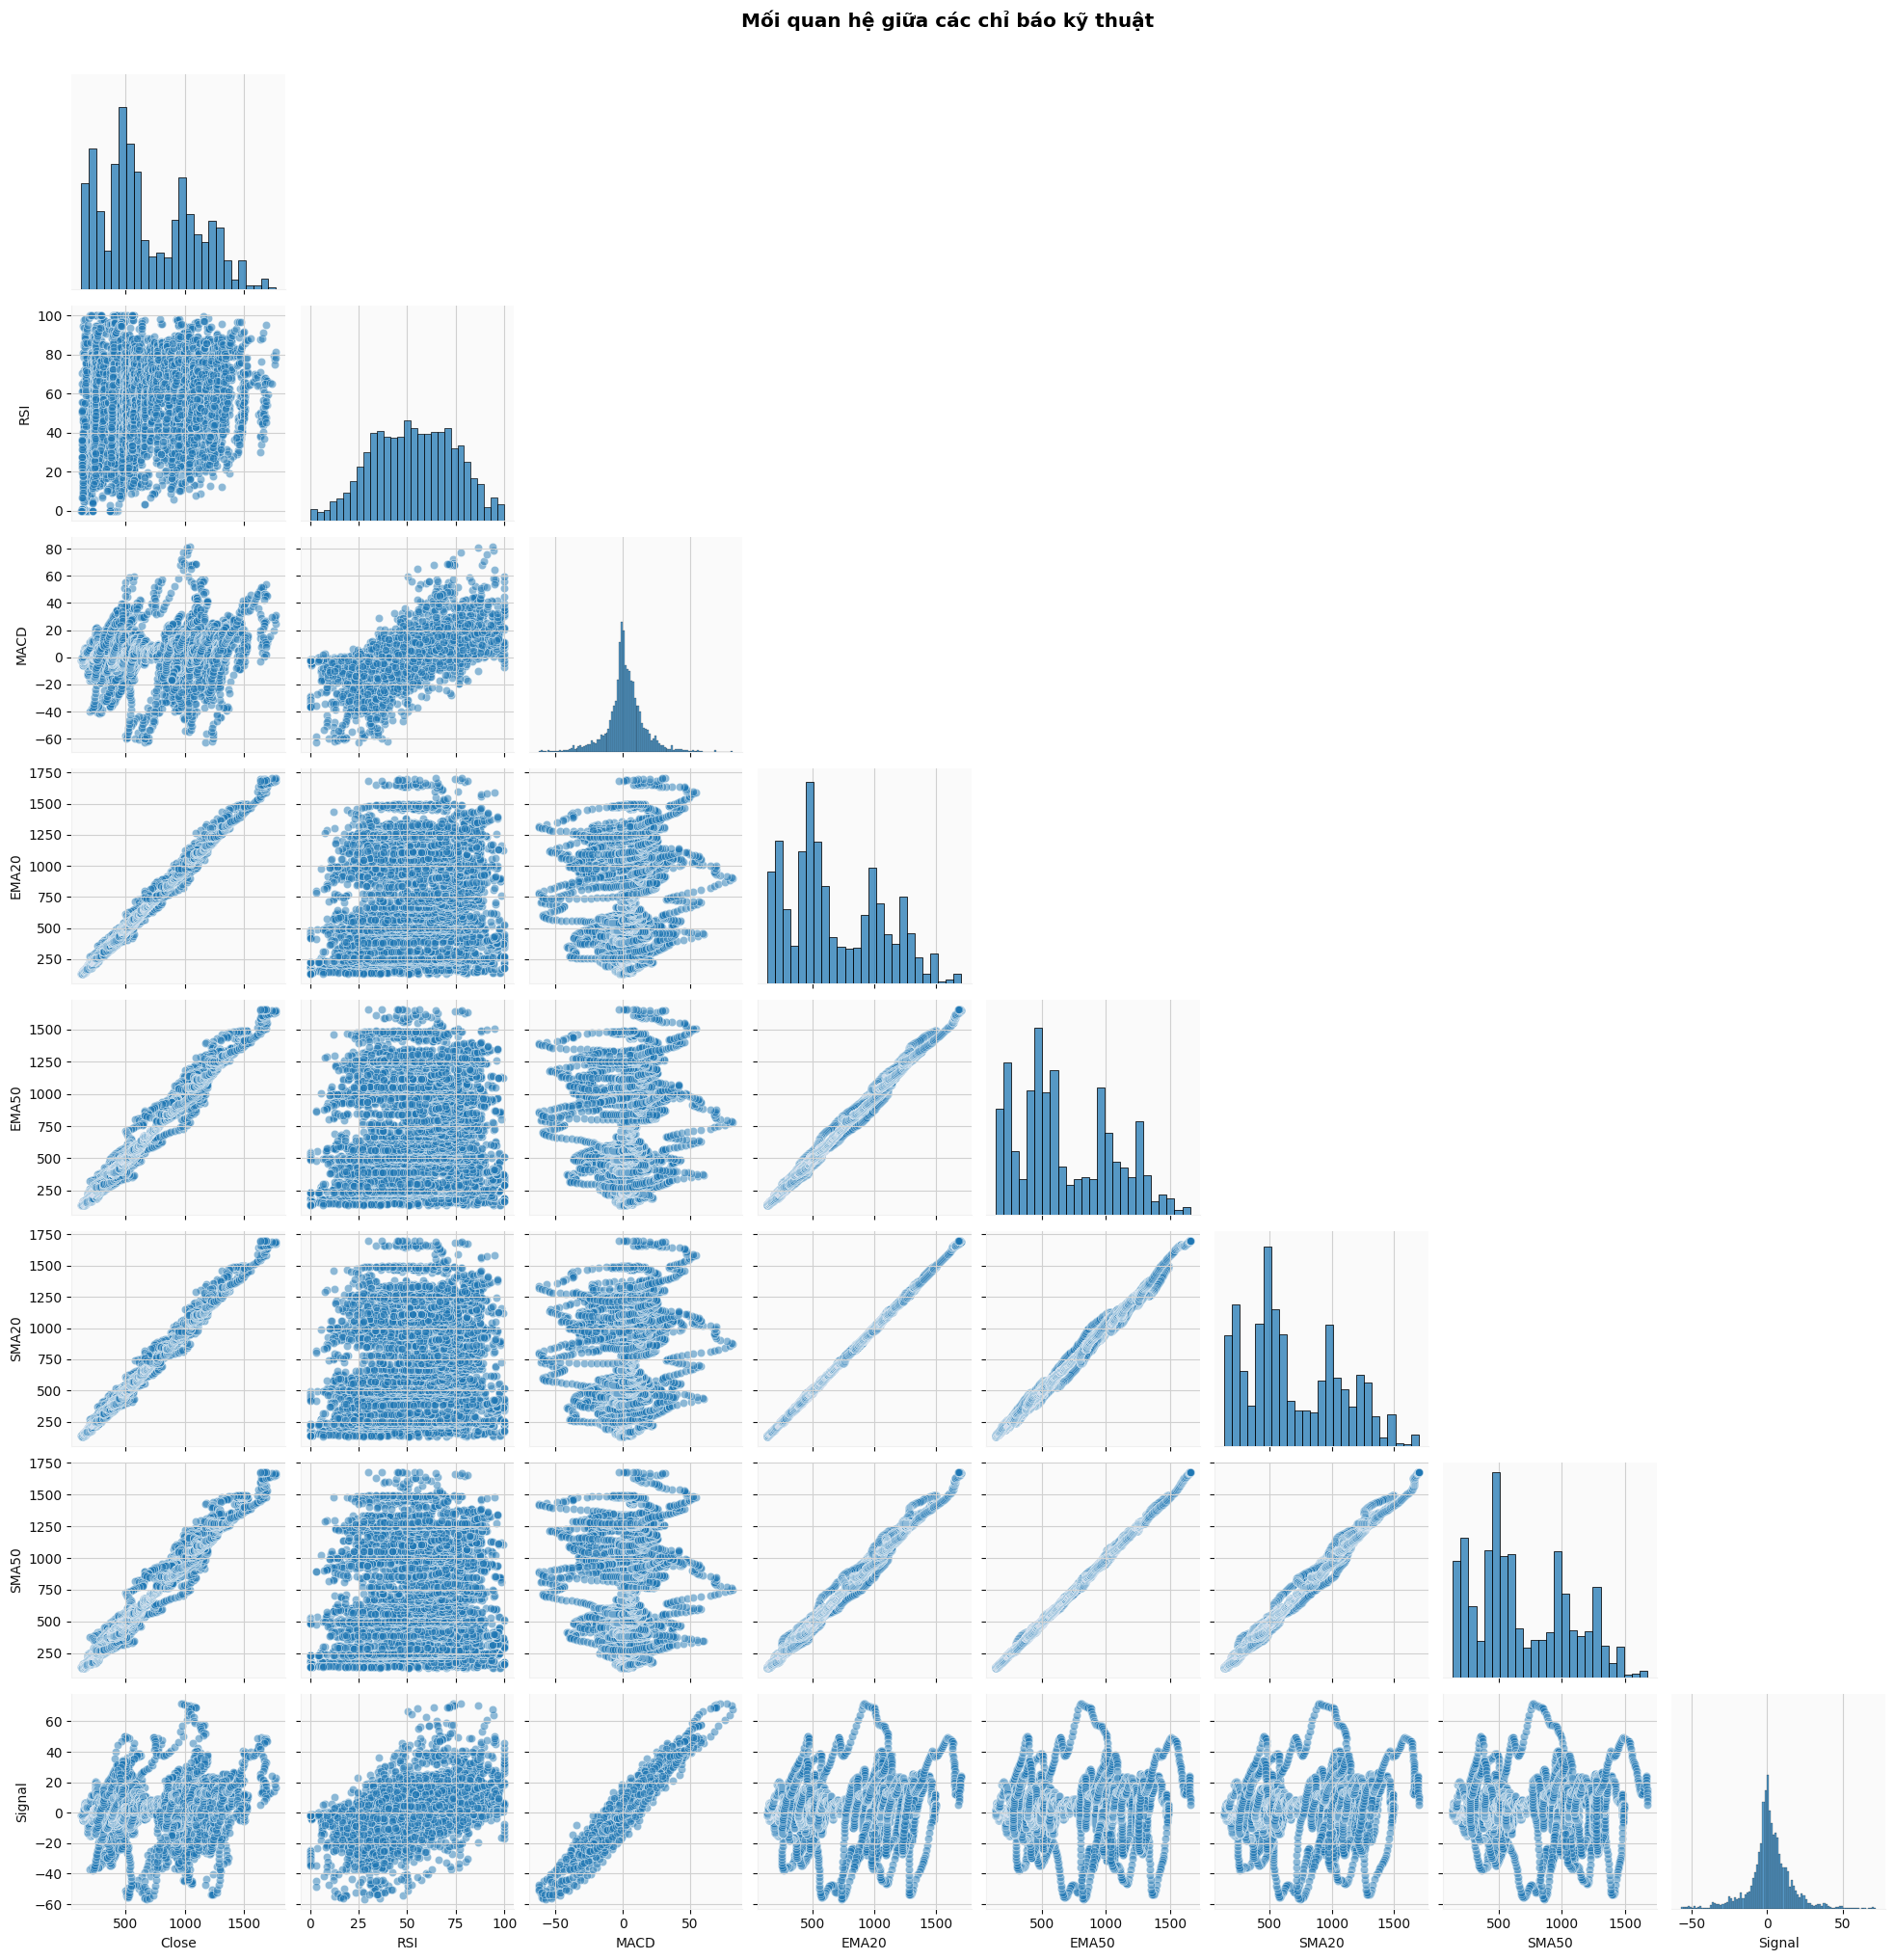

In [416]:

cols_pair = [col for col in ['Close', 'RSI', 'MACD', 'EMA20', 'EMA50', 'SMA20', 'SMA50', 'Signal'] if col in df.columns]

if len(cols_pair) >= 2:
    sns.pairplot(df[cols_pair], corner=True, plot_kws={'alpha':0.5})
    plt.suptitle('Mối quan hệ giữa các chỉ báo kỹ thuật', y=1.02)
    plt.show()
else:
    print("Không đủ biến kỹ thuật để vẽ pairplot.")


In [417]:
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
num_cols = [col for col in num_cols if col not in ['Date']] 
df_num = df[num_cols]
df_num.head()


,Close,Open,High,Low,Volume,Change_pct,Usd/vnd,EMA20,EMA50,SMA20,SMA50,BB_Middle,BB_Upper,BB_Lower,BB_Width,RSI,MACD,Signal
49,250.23,250.23,250.23,250.23,30.0,1.80,14541.0,216.479266,185.453670,214.2515,174.8240,214.2515,255.205117,173.297883,0.382295,100.000000,20.346353,18.419140
50,259.93,259.93,259.93,259.93,10.0,1.95,14548.0,220.617431,188.374310,217.7510,177.6042,217.7510,261.801785,173.700215,0.404598,100.000000,21.317905,18.998893
51,260.15,260.15,260.15,260.15,320.0,0.08,14551.0,224.382438,191.189043,221.5345,180.3844,221.5345,266.541303,176.527697,0.406319,100.000000,21.853704,19.569855
52,256.18,256.18,256.18,256.18,130.0,-1.53,14549.0,227.410777,193.737708,224.9625,183.0638,224.9625,269.534741,180.390259,0.396264,93.070344,21.707749,19.997434
53,252.21,252.21,252.21,252.21,80.0,-1.55,14552.0,229.772608,196.030739,228.0175,185.6214,228.0175,271.173340,184.861660,0.378531,86.198505,21.029320,20.203811


In [418]:
# Tính VIF cho từng biến
vif_data = pd.DataFrame()
vif_data["Feature"] = df_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i) for i in range(df_num.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
vif_data


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,Feature,VIF
0,SMA20,inf
1,BB_Lower,inf
2,BB_Upper,inf
3,BB_Middle,inf
4,EMA20,2.235752e+05
5,Close,7.513728e+04
6,High,6.936638e+04
7,Open,5.900384e+04
8,Low,4.263971e+04
9,SMA50,4.072505e+04


/var/folders/1c/h3mcrjs96pxbb_6hcly26ygm0000gn/T/ipykernel_22539/2703253132.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=vif_data, x="VIF", y="Feature", palette="viridis")


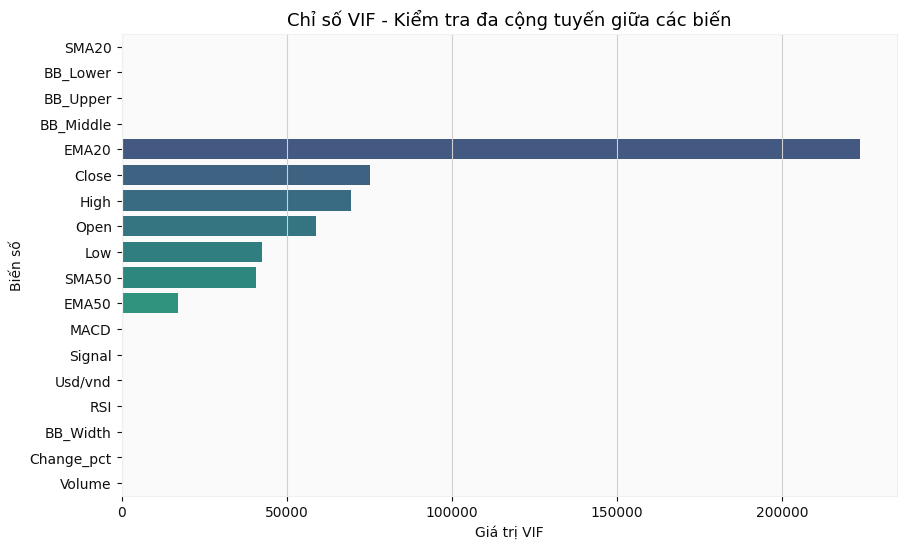

In [419]:
plt.figure(figsize=(10,6))
sns.barplot(data=vif_data, x="VIF", y="Feature", palette="viridis")
plt.title("Chỉ số VIF - Kiểm tra đa cộng tuyến giữa các biến", fontsize=13)
plt.xlabel("Giá trị VIF")
plt.ylabel("Biến số")
plt.show()


In [420]:
df.columns

Index(['Date', 'Close', 'Open', 'High', 'Low', 'Volume', 'Change_pct',
       'Usd/vnd', 'EMA20', 'EMA50', 'SMA20', 'SMA50', 'BB_Middle', 'BB_Upper',
       'BB_Lower', 'BB_Width', 'RSI', 'MACD', 'Signal'],
      dtype='object')

In [421]:
df.head()


,Date,Close,Open,High,Low,Volume,Change_pct,Usd/vnd,EMA20,EMA50,SMA20,SMA50,BB_Middle,BB_Upper,BB_Lower,BB_Width,RSI,MACD,Signal
49,2001-02-02,250.23,250.23,250.23,250.23,30.0,1.80,14541.0,216.479266,185.453670,214.2515,174.8240,214.2515,255.205117,173.297883,0.382295,100.000000,20.346353,18.419140
50,2001-02-07,259.93,259.93,259.93,259.93,10.0,1.95,14548.0,220.617431,188.374310,217.7510,177.6042,217.7510,261.801785,173.700215,0.404598,100.000000,21.317905,18.998893
51,2001-02-09,260.15,260.15,260.15,260.15,320.0,0.08,14551.0,224.382438,191.189043,221.5345,180.3844,221.5345,266.541303,176.527697,0.406319,100.000000,21.853704,19.569855
52,2001-02-12,256.18,256.18,256.18,256.18,130.0,-1.53,14549.0,227.410777,193.737708,224.9625,183.0638,224.9625,269.534741,180.390259,0.396264,93.070344,21.707749,19.997434
53,2001-02-14,252.21,252.21,252.21,252.21,80.0,-1.55,14552.0,229.772608,196.030739,228.0175,185.6214,228.0175,271.173340,184.861660,0.378531,86.198505,21.029320,20.203811
